# Alexandre AUTRET, DIA1, Python for Data Analysis

### Unmanned Aerial Vehicle (UAV) Intrusion Detection Data Set

_Liang Zhao, Amir Alipour-Fanid, Martin Slawski and Kai Zeng. Prediction-time Efficient Classification Using Feature Computational Dependencies. In Proceedings of the 24st ACM SIGKDD Conference on Knowledge Discovery and Data Mining (KDD 2018), research track (acceptance rate: 18.4%), London, United Kingdom, Aug 2018, Pages 2787-2796._

The goal of this project is to build a model that predicts whether a UAV has been hijacked or not.

The first dataset contains information of a Parrot Bebop drone in bidirectional-flow mode. The next 2 are for a DBPower UDI and a DJI Spark in the same communication mode. The last 3 datasets are for unidirectional-flow mode for the same 3 drones respectively. Since unidirectional-flow mode doesn't distinguish between each direction flow (uplink, downlink or both-link), it can only be less accurate. Also, as stated on the dataset's website, the number of features is different from the first 3 datasets (54) to the last 3 (18), so we need to choose one of the 2 modes for our model, and we can't use it to do testing on the datasets for the other mode.
For these reasons, we'll restrain the scope of this project to UAV information in bidirectional-flow mode, and therefore only use the first 3 datasets.

### Exploring our first dataset, which we'll use for our training model

Let's import the necessary libraries:

In [1]:
%matplotlib inline
from h5py import File #needed to read our data set, which is an HDF5 mat file
import numpy as np
import pandas as pd

Let's read our data and store it as a pandas DataFrame:

In [2]:
with File("pub_dataset1.mat", "r") as file_dict:
    cols = ["col{}".format(i) for i in range(len(file_dict["data_tr"]))] #data_tr is the training set
    vals = np.array([[val for val in col] for col in file_dict["data_tr"]]) #returns the transpose of the data matrix we want
    tr_data = pd.DataFrame(vals.T, columns=cols) #so we transpose it here

To make the data more readable, let's rename the columns to what they represent (information available on the website):

In [3]:
new_cols = ["uplink_size_mean", "uplink_size_median", "uplink_size_MAD", "uplink_size_STD", "uplink_size_Skewness",
            "uplink_size_Kurtosis", "uplink_size_MAX", "uplink_size_MIN", "uplink_size_MeanSquare", "downlink_size_mean",
            "downlink_size_median", "downlink_size_MAD", "downlink_size_STD", "downlink_size_Skewness", "downlink_size_Kurtosis",
            "downlink_size_MAX", "downlink_size_MIN", "downlink_size_MeanSquare", "both_links_size_mean", "both_links_size_median",
            "both_links_size_MAD", "both_links_size_STD", "both_links_size_Skewness", "both_links_size_Kurtosis", "both_links_size_MAX",
            "both_links_size_MIN", "both_links_size_MeanSquare", "uplink_interval_mean", "uplink_interval_median", "uplink_interval_MAD",
            "uplink_interval_STD", "uplink_interval_Skewness", "uplink_interval_Kurtosis", "uplink_interval_MAX", "uplink_interval_MIN",
            "uplink_interval_MeanSquare", "downlink_interval_mean", "downlink_interval_median", "downlink_interval_MAD", "downlink_interval_STD",
            "downlink_interval_Skewness", "downlink_interval_Kurtosis", "downlink_interval_MAX", "downlink_interval_MIN", "downlink_interval_MeanSquare", 
            "both_links_interval_mean", "both_links_interval_median", "both_links_interval_MAD", "both_links_interval_STD", "both_links_interval_Skewness",
            "both_links_interval_Kurtosis", "both_links_interval_MAX", "both_links_interval_MIN", "both_links_interval_MeanSquare", "label"]
tr_data.columns = new_cols

Let's get some information about this DataFrame:

In [4]:
print("This data set has {0} rows and {1} columns:\n".format(*tr_data.shape))
tr_data.head()

This data set has 1751 rows and 55 columns:



,uplink_size_mean,uplink_size_median,uplink_size_MAD,uplink_size_STD,uplink_size_Skewness,uplink_size_Kurtosis,uplink_size_MAX,uplink_size_MIN,uplink_size_MeanSquare,downlink_size_mean,...,both_links_interval_mean,both_links_interval_median,both_links_interval_MAD,both_links_interval_STD,both_links_interval_Skewness,both_links_interval_Kurtosis,both_links_interval_MAX,both_links_interval_MIN,both_links_interval_MeanSquare,label
0,0.013633,0.009907,0.012473,0.013195,0.206939,-1.518004,0.029022,0.000002,0.016793,113.612245,...,125.07,148.422224,126.0,83.0256,6.183629,39.041176,1130.0,70.0,193.523564,1.0
1,0.176876,0.328222,0.050990,0.072377,2.746796,7.799352,1.629773,0.000309,0.369391,487.000000,...,383.66,313.268698,307.0,126.0210,2.542834,5.425483,1476.0,216.0,494.318622,0.0
2,0.003496,0.004608,0.001605,0.001622,1.884811,2.649103,0.018668,0.000177,0.005718,96.857143,...,451.19,414.950105,150.0,109.7124,0.358598,-1.731709,1108.0,76.0,611.583330,1.0
3,0.004229,0.005576,0.000986,0.001195,1.088090,-0.287253,0.018410,0.000009,0.006926,98.225806,...,444.06,389.912910,147.0,105.2646,0.311359,-1.699683,1094.0,76.0,589.661801,1.0
4,0.003080,0.005691,0.000934,0.000975,2.881301,8.274496,0.026786,0.000011,0.006387,96.533333,...,483.52,404.892316,417.0,505.5666,0.198671,-1.704260,1218.0,76.0,629.356815,1.0


Let's visualize how each variable looks with regards to our target variable:

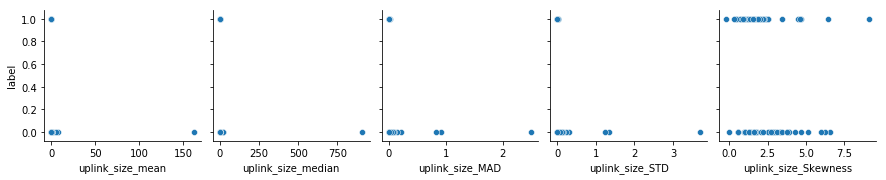

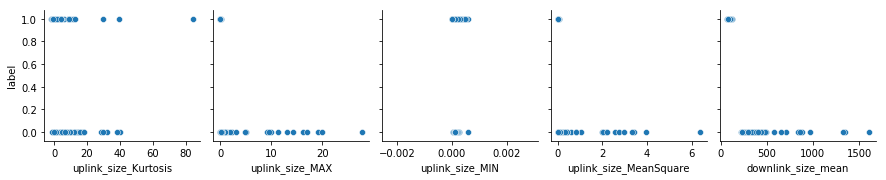

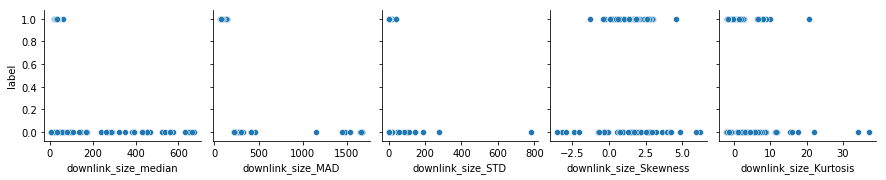

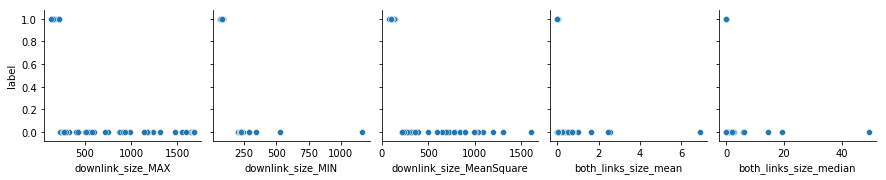

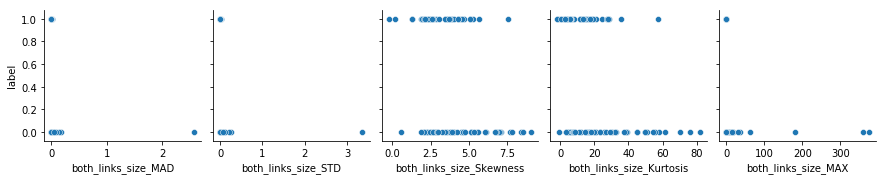

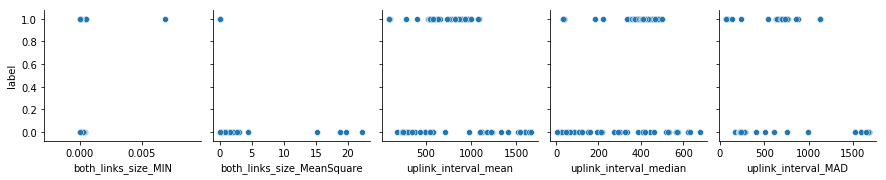

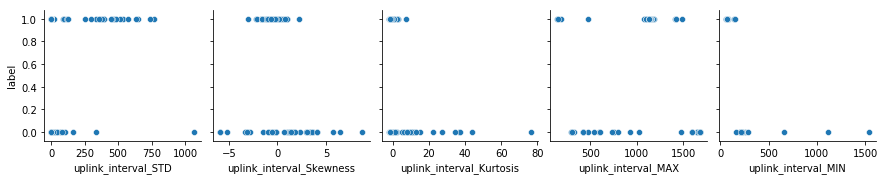

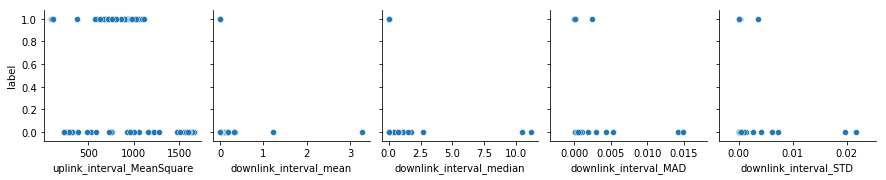

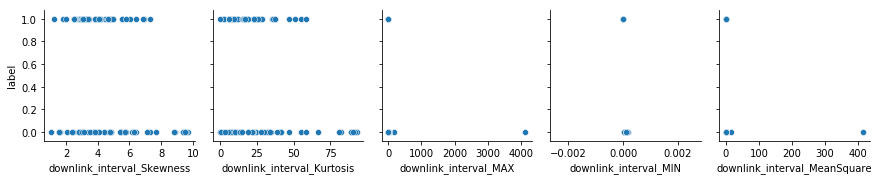

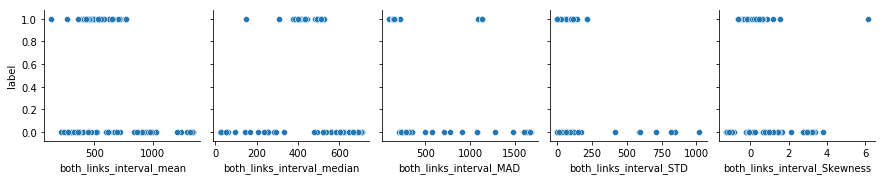

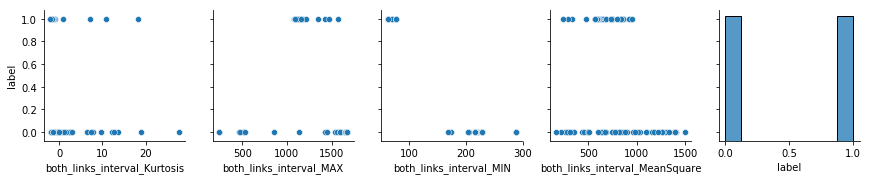

In [5]:
import matplotlib.pyplot as plt
import seaborn as sb
for i in range(11):
    sb.pairplot(data=tr_data.sample(100), y_vars=["label"], x_vars=tr_data.iloc[:, 5*i:5*i+5])
    plt.show()

From what we can gather here, uplink and downlink communication with a hijacked UAV is always close to null.
Most parameters seem relevant to some degree, except uplink_size_MIN, both_links_size_Skewness and both_links_size_Kurtosis.

### Predictive modeling

We want to first train a simple logistic regression, since it seems like it would fit our dataset extremely well: we can expect a sigmoid that drops sharply (almost vertically).

Let's initialize the testing set:

In [6]:
x_train, y_train = tr_data.drop("label", axis=1), tr_data["label"]

with File("pub_dataset1.mat", "r") as file_dict:
    vals = np.array([[val for val in col] for col in file_dict["data_te"]]) #returns the transpose of the data matrix we want
    te_data = pd.DataFrame(vals.T, columns=new_cols) #so we transpose it here
x_test, y_test = te_data.drop("label", axis=1), te_data["label"]

In [7]:
from sklearn.linear_model import LogisticRegression
lm = LogisticRegression(max_iter=10000, solver="lbfgs")
lm.fit(x_train, y_train)
predictions = lm.predict(x_test)

Let's plot the logistic function for a few variables, to get an idea of how it looks:

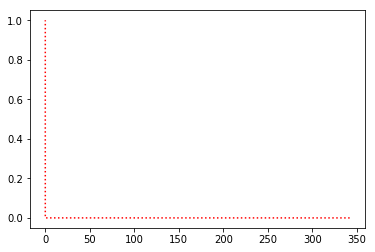

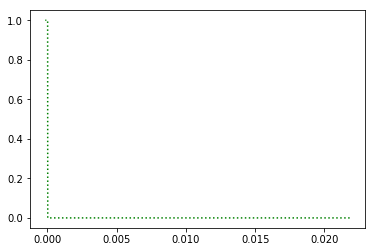

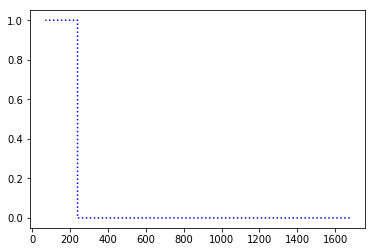

In [8]:
plt.plot(sorted(x_test["uplink_size_MIN"], reverse=True), sorted(lm.predict_proba(x_test)[:,1]), color="red", linestyle=":")
plt.show()
plt.plot(sorted(x_test["both_links_size_MIN"], reverse=True), sorted(lm.predict_proba(x_test)[:,1]), color="green", linestyle=":")
plt.show()
plt.plot(sorted(x_test["downlink_size_MAX"], reverse=True), sorted(lm.predict_proba(x_test)[:,1]), "blue", linestyle=":")
plt.show()

As expected, we get sigmoids that drop sharply.

Let's compute our model's accuracy:

In [9]:
from sklearn.metrics import classification_report
lbls = ["NOT hijacked (0)", "hijacked (1)"]
print(classification_report(y_test, predictions, target_names=lbls))

                  precision    recall  f1-score   support

NOT hijacked (0)       1.00      1.00      1.00      7869
    hijacked (1)       1.00      1.00      1.00      9760

       micro avg       1.00      1.00      1.00     17629
       macro avg       1.00      1.00      1.00     17629
    weighted avg       1.00      1.00      1.00     17629



__We notice that our model has an accuracy and recall of 1, therefore we don't really need a more complex one.__

For the sake of not just having our logistic model, let's also try a random forest model and see how it performs.

In [10]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000)
rf.fit(x_train, y_train)
rf_preds = rf.predict(x_test)
for i in range(len(rf_preds)):
    if rf_preds[i] < 0.5:
        rf_preds[i] = 0.0
    else:
        rf_preds[i] = 1.0
print(classification_report(y_test, rf_preds, target_names=lbls))

                  precision    recall  f1-score   support

NOT hijacked (0)       1.00      1.00      1.00      7869
    hijacked (1)       1.00      1.00      1.00      9760

       micro avg       1.00      1.00      1.00     17629
       macro avg       1.00      1.00      1.00     17629
    weighted avg       1.00      1.00      1.00     17629



This model is very accurate as well, so we don't need to fiddle with any hyperparameter to make it work.

### Testing our model with the 2 other usable testing datasets

Now that we've seen that our base models seem to work perfectly with our testing sets, let's try to use them for the other 2 testing datasets in bidirectional-flow mode:

In [11]:
with File("pub_dataset2.mat", "r") as file_dict:
    vals = np.array([[val for val in col] for col in file_dict["data_te"]]) #returns the transpose of the data matrix we want
    te_data = pd.DataFrame(vals.T, columns=new_cols) #so we transpose it here
    
x_test, y_test = te_data.drop("label", axis=1), te_data["label"]
lm_pred2 = lm.predict(x_test)
lbls = ["NOT hijacked (0)", "hijacked (1)"]
print(classification_report(y_test, lm_pred2, target_names=lbls))

rf_pred2 = rf.predict(x_test)
for i in range(len(rf_pred2)):
    if rf_pred2[i] < 0.5:
        rf_pred2[i] = 0.0
    else:
        rf_pred2[i] = 1.0
lbls = ["NOT hijacked (0)", "hijacked (1)"]
print(classification_report(y_test, rf_pred2, target_names=lbls))

                  precision    recall  f1-score   support

NOT hijacked (0)       1.00      1.00      1.00      7810
    hijacked (1)       1.00      1.00      1.00      7877

       micro avg       1.00      1.00      1.00     15687
       macro avg       1.00      1.00      1.00     15687
    weighted avg       1.00      1.00      1.00     15687

                  precision    recall  f1-score   support

NOT hijacked (0)       1.00      1.00      1.00      7810
    hijacked (1)       1.00      1.00      1.00      7877

       micro avg       1.00      1.00      1.00     15687
       macro avg       1.00      1.00      1.00     15687
    weighted avg       1.00      1.00      1.00     15687



We see that our 2 models seems to perfectly fit the data of the DBPower UDI drone as well.

In [12]:
with File("pub_dataset3.mat", "r") as file_dict:
    vals = np.array([[val for val in col] for col in file_dict["data_te"]]) #returns the transpose of the data matrix we want
    te_data = pd.DataFrame(vals.T, columns=new_cols) #so we transpose it here
    
x_test, y_test = te_data.drop("label", axis=1), te_data["label"]
lm_pred3 = lm.predict(x_test)
lbls = ["NOT hijacked (0)", "hijacked (1)"]
print(classification_report(y_test, lm_pred3, target_names=lbls))

rf_pred3 = rf.predict(x_test)
for i in range(len(rf_pred3)):
    if rf_pred3[i] < 0.5:
        rf_pred3[i] = 0.0
    else:
        rf_pred3[i] = 1.0
lbls = ["NOT hijacked (0)", "hijacked (1)"]
print(classification_report(y_test, rf_pred3, target_names=lbls))

                  precision    recall  f1-score   support

NOT hijacked (0)       1.00      1.00      1.00      2500
    hijacked (1)       1.00      1.00      1.00      2500

       micro avg       1.00      1.00      1.00      5000
       macro avg       1.00      1.00      1.00      5000
    weighted avg       1.00      1.00      1.00      5000

                  precision    recall  f1-score   support

NOT hijacked (0)       1.00      1.00      1.00      2500
    hijacked (1)       1.00      1.00      1.00      2500

       micro avg       1.00      1.00      1.00      5000
       macro avg       1.00      1.00      1.00      5000
    weighted avg       1.00      1.00      1.00      5000



Finally, both models seem to also fit the DJI Spark's data perfectly.